In [ ]:
#The objective is to predict 3 months of item-level sales data at different store locations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import itertools as it
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm

In [2]:
def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        time_series (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Return:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
            
        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])
    
    return results_df

In [3]:
train_df=pd.read_csv("train.csv")

In [4]:
def data_check(df):
    print('=============INFO====================')
    print(df.info())
    print('\n=============HEAD====================')
    print(df.head())
    print('\n=============TAIL====================')
    print(df.tail())
    print('\n==========NULL_VALUES================')
    print(df.isnull().sum())

In [5]:
data_check(train_df)

=============INFO====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

=============HEAD====================
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

=============TAIL====================
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

==========NULL_VALUES================
date     0
store   

In [ ]:
# The data is recorded from 1st Jan 2013 to 31st December 2017
# 5 years

In [6]:
print("Data is recorded from {} to {} in train dataset: ".format(train_df['date'].min(),train_df['date'].max()))

Data is recorded from 2013-01-01 to 2017-12-31 in train dataset: 


In [7]:
print("Total:{},Stores: {}".format(len(train_df["store"].value_counts()),list(train_df["store"].value_counts().index)))
print("Total:{},Items: {}".format(len(train_df["item"].value_counts()),list(train_df["item"].value_counts().sort_index().index)))

Total:10,Stores: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Total:50,Items: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [8]:
#each item sales from a particular store
store_items_df=train_df.groupby(['store','item']).agg({'sales': ['sum']})
store_items_df.columns = ['Total_sales']
store_items_df = store_items_df.reset_index()
print(store_items_df.head())
print(store_items_df.tail())

   store  item  Total_sales
0      1     1        36468
1      1     2        97050
2      1     3        60638
3      1     4        36440
4      1     5        30335
     store  item  Total_sales
495     10    46       120601
496     10    47        45204
497     10    48       105570
498     10    49        60317
499     10    50       135192


In [9]:
#Highest selling item from store 1
max_sales_in_store_1=store_items_df[store_items_df["store"]==1]['Total_sales'].max()
store_items_df[(store_items_df["store"]==1) & (store_items_df['Total_sales']== max_sales_in_store_1)]

,store,item,Total_sales
14,1,15,145497


In [10]:
# Highest selling item among all stores
max_sales_among_all_store=store_items_df['Total_sales'].max()
store_items_df[store_items_df['Total_sales']== max_sales_among_all_store]


,store,item,Total_sales
77,2,28,205677


In [ ]:
#Highest selling item from store 1 is item:15
#Highest selling item from store 2 is item:28

In [11]:
#lets see highest sales are from which store
train_df[['store','sales']].groupby('store',as_index=False).sum().sort_values('sales', ascending=False)

,store,sales
1,2,6120128
7,8,5856169
2,3,5435144
9,10,5360158
8,9,5025976
3,4,5012639
0,1,4315603
4,5,3631016
5,6,3627670
6,7,3320009


In [ ]:
#Highest sales are from Store:2 followed by store:8

<AxesSubplot:title={'center':'Number of sales per store.'}, xlabel='store', ylabel='sales'>

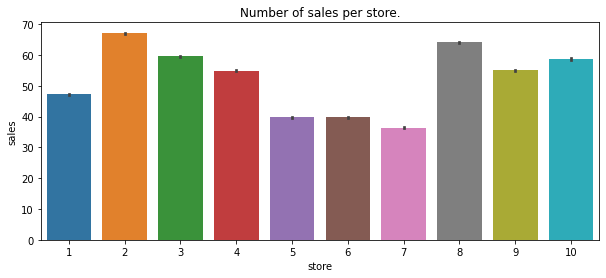

In [12]:
plt.figure(figsize=(10,4))
plt.title("Number of sales per store.")
sns.barplot(data=train_df,x='store',y='sales')

In [13]:
#Which item is sold max in store 2?
max_store2=store_items_df[store_items_df["store"]==2]['Total_sales'].max()
store_items_df.loc[((store_items_df["store"]==2) & (store_items_df['Total_sales']== max_store2)),'item'].iloc[0]

28

In [ ]:
# The item 28 is sold more in store 2.
# Also it the most sold item in all stores.

In [14]:
#Maximum Sales per store from 1 to 10.
maximum_sales_per_store=[]

#Maximum Sales per store from 1 to 10.
maximum_sold_item_per_store=[]


In [15]:
for i in range(0,10):
    max_sales=store_items_df[store_items_df["store"]==i+1]['Total_sales'].max()
    maximum_sales_per_store.append(max_sales)
    maximum_sold_item_per_store.append(store_items_df.loc[((store_items_df["store"]==i+1) & (store_items_df['Total_sales']== max_sales)),'item'].iloc[0])

In [16]:
stores_list=list(train_df.groupby("store").groups.keys())

In [17]:
max_sold_items_dict={
    
    "Store_id":stores_list,
    "Maximum_sold_item":maximum_sold_item_per_store,
    "Total_sales_for_item":maximum_sales_per_store
    
}

In [18]:
maximum_sold_item_per_store

[15, 28, 15, 15, 15, 15, 15, 15, 15, 15]

In [19]:
maximum_sales_per_store

[145497,
 205677,
 183373,
 169186,
 122319,
 121737,
 111640,
 197295,
 170069,
 180757]

In [20]:
max_sold_items_df=pd.DataFrame.from_dict(data=max_sold_items_dict)

In [21]:
max_sold_items_df

,Store_id,Maximum_sold_item,Total_sales_for_item
0,1,15,145497
1,2,28,205677
2,3,15,183373
3,4,15,169186
4,5,15,122319
5,6,15,121737
6,7,15,111640
7,8,15,197295
8,9,15,170069
9,10,15,180757


<AxesSubplot:title={'center':'Number of sales in store-1.'}, xlabel='item', ylabel='Total_sales'>

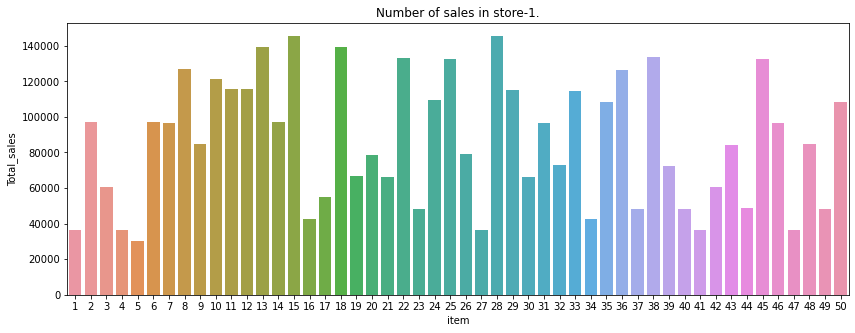

In [22]:
plt.figure(figsize=(14,5))
plt.title("Number of sales in store-1.")
sns.barplot(data=store_items_df[store_items_df['store']==1],x='item',y='Total_sales')

In [ ]:
#from the above picture the items 15 and 28 look like they have highest sales. 
#but the exact item number cant be found from visualisation

In [ ]:
# max_sold_items_df this dataframe suffices our work to 
# findout the item having the highest number of sales.

In [ ]:
#convert the date column from object type to Datetime type

In [23]:
train_df['date']= pd.to_datetime(train_df['date'])

In [24]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday #monday-0;tuesday-1;---- ;saturday-5;sunday-6;
train_df['year-month'] = train_df['date'].apply(lambda x: str(x.year)+'-'+str(x.month))

In [25]:
train_df.head(5)

,date,store,item,sales,year,month,day,weekday,year-month
0,2013-01-01,1,1,13,2013,1,1,1,2013-1
1,2013-01-02,1,1,11,2013,1,2,2,2013-1
2,2013-01-03,1,1,14,2013,1,3,3,2013-1
3,2013-01-04,1,1,13,2013,1,4,4,2013-1
4,2013-01-05,1,1,10,2013,1,5,5,2013-1


In [26]:
train_df.tail(5)

,date,store,item,sales,year,month,day,weekday,year-month
912995,2017-12-27,10,50,63,2017,12,361,2,2017-12
912996,2017-12-28,10,50,59,2017,12,362,3,2017-12
912997,2017-12-29,10,50,74,2017,12,363,4,2017-12
912998,2017-12-30,10,50,62,2017,12,364,5,2017-12
912999,2017-12-31,10,50,82,2017,12,365,6,2017-12


In [27]:
#Analyse the sales per month in the year-2013
month_data_2013_df=train_df[train_df['year']==2013].groupby(['month']).agg({'sales': ['sum']})

<AxesSubplot:title={'center':'monthly sales for year 2013'}, xlabel='month', ylabel='sales'>

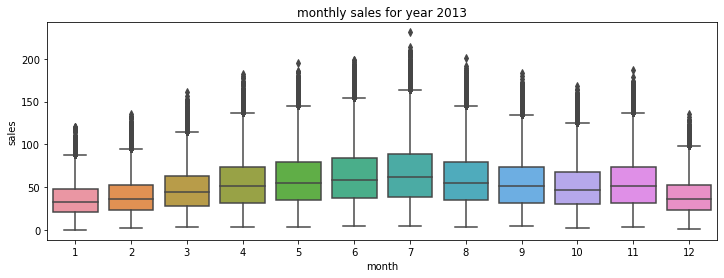

In [28]:
plt.figure(figsize=(12,4))
plt.title('monthly sales for year 2013')
sns.boxplot(x='month',y='sales',data=train_df)

In [ ]:
# in general the sales are more in the month of july and low in jan and dec
# the sales are usually high on weekends- saturday and sunday

<AxesSubplot:title={'center':'monthly sales'}, xlabel='month', ylabel='sales'>

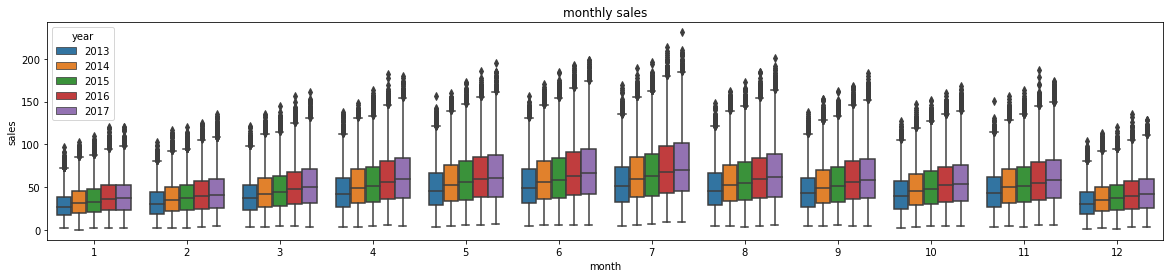

In [29]:
plt.figure(figsize=(20,4))
plt.title('monthly sales')
sns.boxplot(x='month',y='sales',data=train_df,hue='year')

<AxesSubplot:title={'center':'monthly sales'}, xlabel='month', ylabel='sales'>

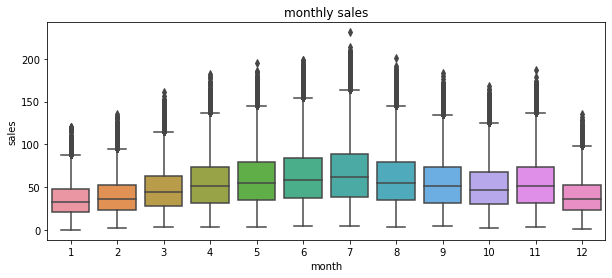

In [30]:
plt.figure(figsize=(10,4))
plt.title('monthly sales')
sns.boxplot(x='month',y='sales',data=train_df)

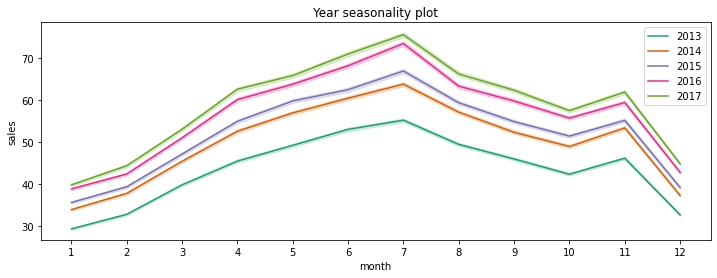

In [31]:
plt.figure(figsize=(12,4))
sns.lineplot(x='month', 
             y='sales', 
             hue='year', 
             legend='full',
            palette='Dark2',
            data=train_df )

# add title
plt.title('Year seasonality plot')
plt.xticks(np.arange(1, 13, step=1))
plt.legend()



In [ ]:
#in all the 5 years the sales go high in july

<AxesSubplot:title={'center':'Sales per Year-Month'}, xlabel='year-month', ylabel='sales'>

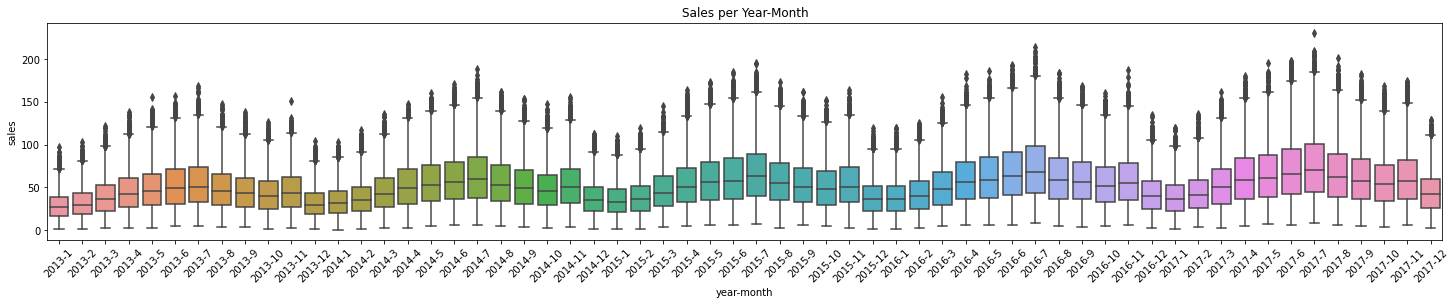

In [32]:
plt.figure(figsize=(25,4))
plt.xticks(rotation=45)
plt.title('Sales per Year-Month')
sns.boxplot(x="year-month", y="sales", data=train_df)

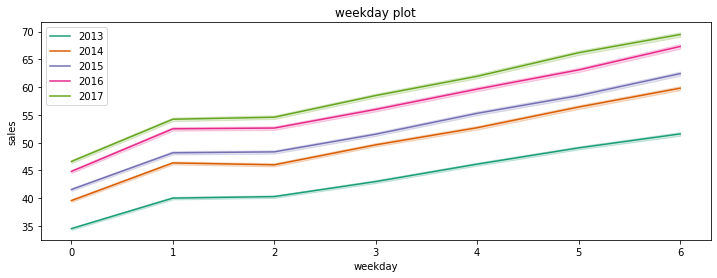

In [35]:
plt.figure(figsize=(12,4))
sns.lineplot(x='weekday', y='sales',  hue='year', legend='full',palette='Dark2',data=train_df )

# add title
plt.title('weekday plot')
plt.xticks(np.arange(0, 7, step=1))
plt.legend()


In [ ]:
#The sales are high on weekend in all the years
# also the volume of sales are increasing year on year
# there is great shift in the amount of sales from the year 2013 to 2014

<AxesSubplot:title={'center':'Sales per week day.'}, xlabel='weekday', ylabel='sales'>

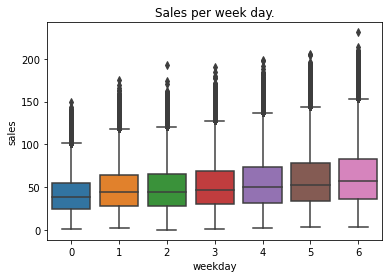

In [36]:
plt.title("Sales per week day.")
sns.boxplot(x="weekday", y="sales", data=train_df)

In [ ]:
# #50 items are present per store
# so overall we need forecasts for 50* 10 items

In [ ]:
# lets start our work with highest sold item in store-1. i.e., item-15
# also item 15 is the highest sold item across all the stores except store-2

In [37]:
store_1_item_15_df=train_df[(train_df['store']==1) & (train_df['item']==15)].reset_index(drop=True)
#5 years from 2013 to 2017
#365*5 days info + 1 day feb29 in year 2016 =1826 entries for store_1_item_15_df

In [38]:
store_1_item_15_df.head()

,date,store,item,sales,year,month,day,weekday,year-month
0,2013-01-01,1,15,42,2013,1,1,1,2013-1
1,2013-01-02,1,15,33,2013,1,2,2,2013-1
2,2013-01-03,1,15,45,2013,1,3,3,2013-1
3,2013-01-04,1,15,39,2013,1,4,4,2013-1
4,2013-01-05,1,15,47,2013,1,5,5,2013-1


In [39]:
store_1_item_15_df.shape

(1826, 9)

In [40]:
store_1_item_15_df.set_index('date',inplace=True)

<AxesSubplot:xlabel='date'>

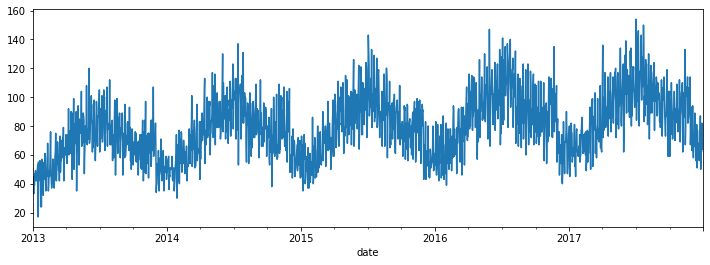

In [41]:
plt.figure(figsize=(12,4))
(store_1_item_15_df['sales']).plot()

In [ ]:
'''
there is trend and seasonality
the model looks like non stationary
from visualisation it looks like additive model
linear trend and the variance the constant

'''

In [42]:
#create a df for sales 
store_1_item_15_ts_df=store_1_item_15_df['sales']

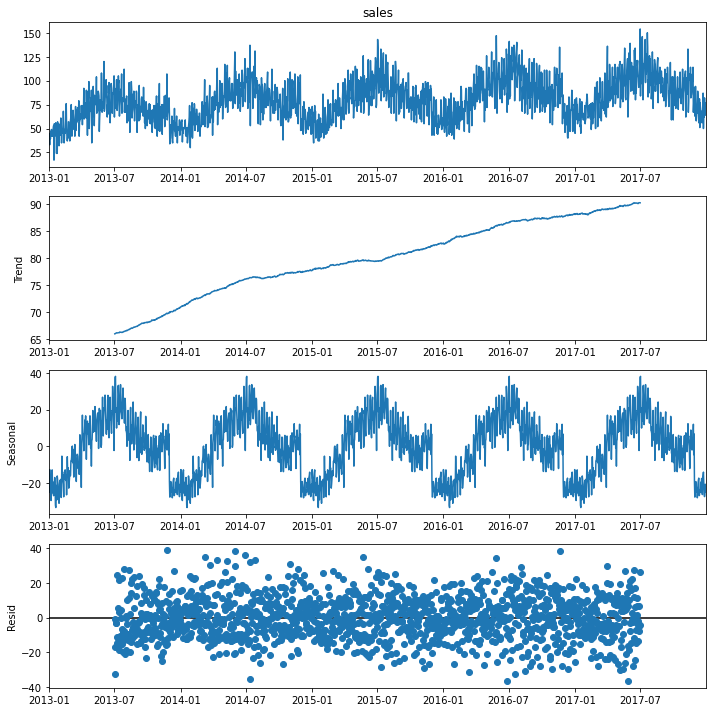

In [57]:
#Analyse by decomposing the data

decomp_add = sm.tsa.seasonal_decompose(store_1_item_15_ts_df, model="additive",period=365)
plt.rcParams['figure.figsize']=(10,10)
fig = decomp_add.plot()
plt.show()

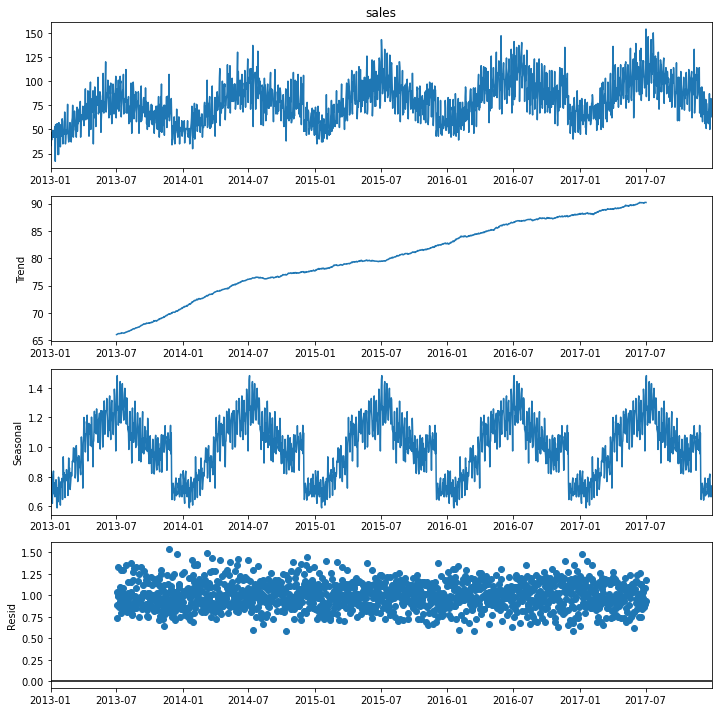

In [44]:
decomp_mul = sm.tsa.seasonal_decompose(store_1_item_15_ts_df, model="multipliocative",period=365)
plt.rcParams['figure.figsize']=(10,10)
decomp_mul.plot()
plt.show()

In [ ]:
# there is a linear trend in the data
# the seasonal factor doesnt change with trend. It just repeats after 12 months.
# the residuals are centered around zero for additive model

In [ ]:
#The residuals plotted should not be following any kind of pattern, it should be spread randomly.

#We can see that the trend and seasonality information extracted from the series does seem reasonable.

#decomposing using additive model will represent the series as a 
#sum of seasonality, trend and residual. 

In [61]:
df_reconstructed = pd.concat([decomp_add.seasonal, decomp_add.trend, decomp_add.resid, decomp_add.observed], axis = 1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.loc['2014-01-01':'2014-01-31']

,seas,trend,resid,actual_values
date,,,,
2014-01-01,-24.742210,70.934247,1.807963,48.0
2014-01-02,-12.549059,71.024658,-3.475598,55.0
2014-01-03,-17.297004,71.063014,3.233991,57.0
2014-01-04,-18.314128,71.106849,5.207278,58.0
2014-01-05,-28.323032,71.186301,16.136730,59.0
2014-01-06,-29.323032,71.104110,-5.781078,36.0
2014-01-07,-17.120977,71.153425,-8.032448,46.0
2014-01-08,-14.173717,71.175342,-12.001626,45.0
2014-01-09,-12.703854,71.197260,-7.493407,51.0


In [ ]:
'''
Returns
-------
DecomposeResult
    A object with seasonal, trend, and resid attributes.


decomp_add.trend
decomp_add.seasonal
decomp_add.resid

output from seasonal decompose
'''

In [64]:
obtain_adf_kpss_results(store_1_item_15_ts_df,3)

C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,1.907955e-02,0.01,True,False,False
1,1,5.644822e-16,0.10,True,True,True
2,2,5.398761e-27,0.10,True,True,True


In [ ]:
#we can apply the d=1 to make the data stationary

In [65]:
store_1_item_15_df['diff_1']=store_1_item_15_df['sales']-store_1_item_15_df['sales'].shift()

In [66]:
store_1_item_15_df.head()

,store,item,sales,year,month,day,weekday,year-month,diff_1
date,,,,,,,,,
2013-01-01,1,15,42,2013,1,1,1,2013-1,NaN
2013-01-02,1,15,33,2013,1,2,2,2013-1,-9.0
2013-01-03,1,15,45,2013,1,3,3,2013-1,12.0
2013-01-04,1,15,39,2013,1,4,4,2013-1,-6.0
2013-01-05,1,15,47,2013,1,5,5,2013-1,8.0


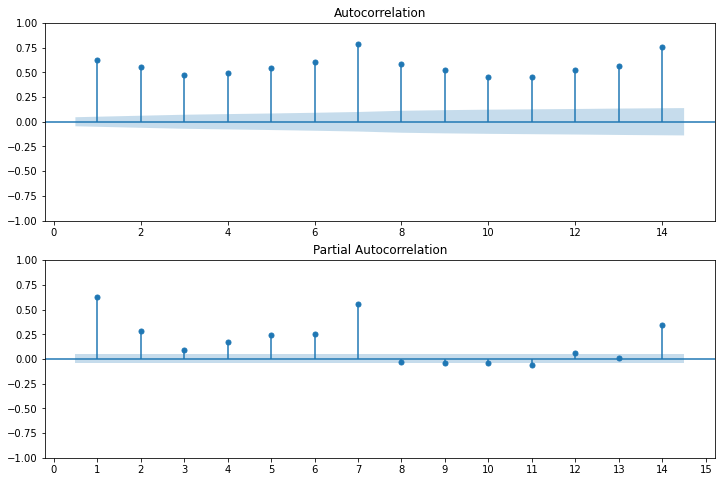

In [67]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of store_1_item_15_ts_df ax1
plot_acf(store_1_item_15_ts_df,lags=14, zero=False, ax=ax1)
plt.xticks(np.arange(0,16,step=1))

# Plot the PACF of store_1_item_15_ts_df ax2
plot_pacf(store_1_item_15_ts_df,lags=14, zero=False, ax=ax2)
plt.xticks(np.arange(0,16,step=1))

plt.show()

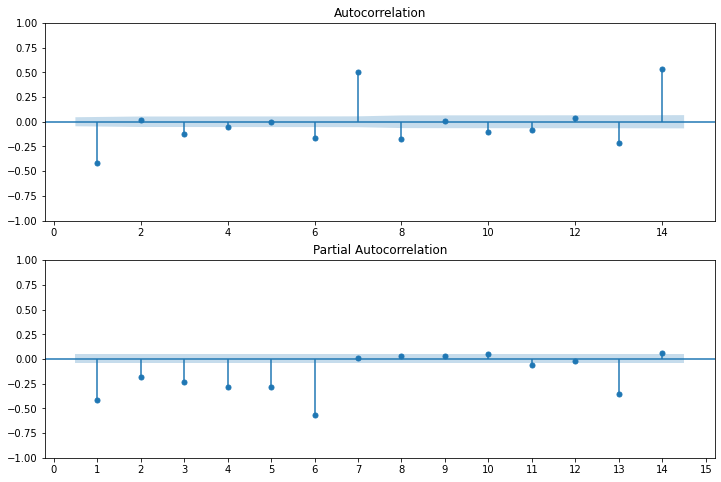

In [68]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(store_1_item_15_df['diff_1'].dropna(),lags=14, zero=False, ax=ax1)
plt.xticks(np.arange(0,16,step=1))

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(store_1_item_15_df['diff_1'].dropna(),lags=14, zero=False, ax=ax2)
plt.xticks(np.arange(0,16,step=1))
plt.show()

In [ ]:
#MA order -6
#there is seasonal component 

In [69]:
# Take the first and seasonal differences (S=7) and drop NaNs
store_1_item_15_df['diff_2']=store_1_item_15_df['sales'].diff().diff(7)

In [89]:
store_1_item_15_df['diff_3']=store_1_item_15_df['sales'].diff(7)

In [ ]:
#q=6 d=1 arima order (0,1,6)

In [ ]:
#finding the seasonal order 

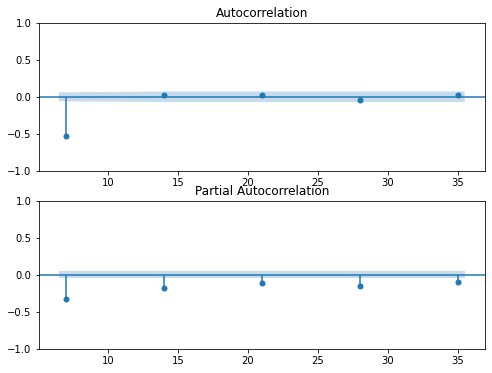

In [70]:
# Make list of lags
lags = [7, 14, 21, 28, 35]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(store_1_item_15_df['diff_2'].dropna(), lags=lags, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(store_1_item_15_df['diff_2'].dropna(), lags=lags, zero=False, ax=ax2)

plt.show()

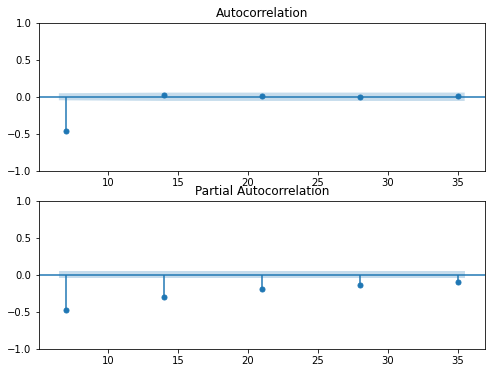

In [90]:
# Make list of lags
lags = [7, 14, 21, 28, 35]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(store_1_item_15_df['diff_3'].dropna(), lags=lags, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(store_1_item_15_df['diff_3'].dropna(), lags=lags, zero=False, ax=ax2)

plt.show()

In [ ]:
#Q=1

In [ ]:
#lets try with the loop to find the order of arima
#from the plots it seems like the 0,1,6 without inlcuding the seasonal component

In [71]:
p=q=range(0,7)
d=range(0,2)
pdq= list(it.product(p,d,q))

In [72]:
order_aic_bic=[]
# Loop over pdq values from list(pdq)
for params in pdq:
      	# create and fit ARIMA(p,d,q) model
        model = sm.tsa.arima.ARIMA(store_1_item_15_ts_df, order=params) 
        print(model.order)
        results = model.fit()
        # Append order and results tuple
        order_aic_bic.append((params,results.aic, results.bic))

C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 0, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 0, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 0, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 0, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 0, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 0, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 0, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

(0, 1, 0)
(0, 1, 1)
(0, 1, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 1, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 1, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 1, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(0, 1, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

(1, 1, 0)
(1, 1, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 1, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 1, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 1, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 1, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 1, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 0, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2, 1, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 0, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 0, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 0, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 0, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 0, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 0, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 0, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 1, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 1, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 1, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 1, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 1, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 1, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(3, 1, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 0, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 0, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 0, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 0, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 0, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 0, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 0, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 1, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 1, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 1, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 1, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 1, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 1, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(4, 1, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 0, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 0, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 0, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 0, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 0, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 0, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 0, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 1, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 1, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 1, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 1, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 1, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 1, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(5, 1, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 0, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 0, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 0, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 0, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 0, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 0, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 0, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 1, 0)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 1, 1)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 1, 2)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 1, 3)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 1, 4)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 1, 5)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(6, 1, 6)


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [74]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, columns=['pdq','AIC','BIC'])
# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC').head())
print("\n")
print(order_df.sort_values('BIC').head())

          pdq           AIC           BIC
97  (6, 1, 6)  14107.022322  14178.643680
96  (6, 1, 5)  14114.437025  14180.549048
75  (5, 0, 5)  14167.837515  14233.956112
76  (5, 0, 6)  14196.446991  14268.075471
68  (4, 1, 5)  14203.886682  14258.980035


          pdq           AIC           BIC
97  (6, 1, 6)  14107.022322  14178.643680
96  (6, 1, 5)  14114.437025  14180.549048
75  (5, 0, 5)  14167.837515  14233.956112
68  (4, 1, 5)  14203.886682  14258.980035
76  (5, 0, 6)  14196.446991  14268.075471


#we can choose order = 6,1,6
Both AIC and BIC conclude that the best model in this case should be ARIMA(6,1,6).

In [75]:
order_df.to_csv("arima_aic_bic.csv", index=False)

In [76]:
#lets check the summary using the manually interpreted order

In [77]:
arima_model_01 = sm.tsa.arima.ARIMA(store_1_item_15_ts_df, order=(0,1,6))
# fit model
arima_results_01 = arima_model_01.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results_01.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 11.161


In [78]:
store_1_item_15_ts_df.describe()

count    1826.000000
mean       79.680723
std        21.725799
min        17.000000
25%        64.000000
50%        78.000000
75%        94.000000
max       154.000000
Name: sales, dtype: float64

In [79]:
#The average sales for product 15 are 79 and we have MAE as 11.161.
#The model can be improved

In [80]:
arima_results_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(0, 1, 6)   Log Likelihood               -7427.210
Date:                Tue, 10 Jan 2023   AIC                          14868.420
Time:                        10:48:59   BIC                          14906.986
Sample:                    01-01-2013   HQIC                         14882.647
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8446      0.021    -39.882      0.000      -0.886      -0.803
ma.L2          0.1168      0.029      4.092      0.000       0.061       0.173
ma.L3         -0.3309      0.029    -11.437      0.000      -0.388      -0.274
ma.L4          0.2053      0.029      7.117      0.000       0.149       0.262
ma.L5         -0.2628      0.028     -9.383      0.000      -0.318      -0.208
ma.L6          0.3087      0.023     13.589      0.000       0.264       0.353
sigma2       200.4124      6.481     30.924      0.000     187.710     213.115
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 3.68
Prob(Q):                              0.65   Prob(JB):                         0.16
Heteroskedasticity (H):               1.39   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

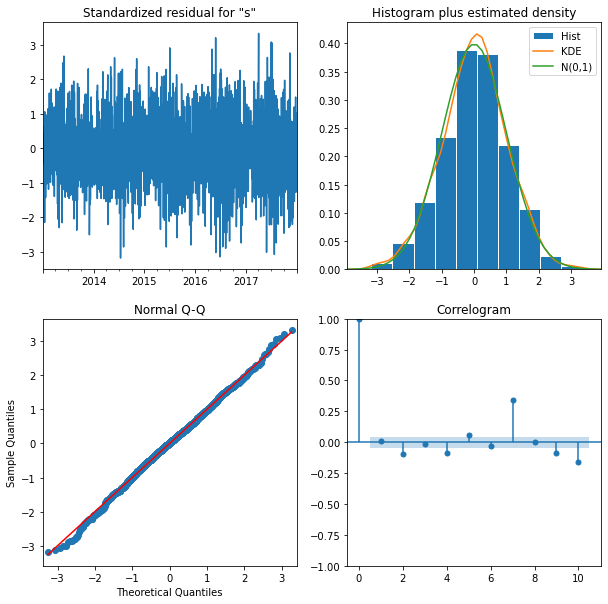

In [81]:
# Create the 4 diagostics plots using plot_diagnostics method
arima_results_01.plot_diagnostics()
plt.show()

In [ ]:
# Null hypothesis:white noise.
#from the Ljung-Box (L1) test we observed that the P(Q)>0.05 and we fail to reject the Null hypothesis:  


# Null hypothesis: Residuals are normally distributed.
#from the Jarque-Bera (JB) test the P(JB)>0.05 and we fail reject the null hypothesis.

#Conclusion:
#residuals are white noise
#the residuals are normally distributed

In [ ]:
# Standardised residuals: No patterns found in them
# Histogram: The KDE is close to the Normal distribution
# Normal Q-Q: Most of the data points should lie on the straight line, indicating a normal distribution of the residuals. 
# This happens here.(There are some points crossing the line)
# Correlogram or ACF plot: 95% of correlations for lag greater than one should not be significant (inside the blue area).
# There are some points outside the blue region.

In [82]:
#lets check the summary using the oder found using the loop

In [83]:
arima_model_02 = sm.tsa.arima.ARIMA(store_1_item_15_ts_df, order=(6,1,6))
# fit model
arima_results_02 = arima_model_02.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results_02.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 9.037


C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [84]:
arima_results_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -7040.511
Date:                Tue, 10 Jan 2023   AIC                          14107.022
Time:                        10:52:24   BIC                          14178.644
Sample:                    01-01-2013   HQIC                         14133.442
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7597      0.143     -5.312      0.000      -1.040      -0.479
ar.L2         -0.0843      0.083     -1.017      0.309      -0.247       0.078
ar.L3         -0.6196      0.040    -15.402      0.000      -0.698      -0.541
ar.L4         -1.0542      0.080    -13.115      0.000      -1.212      -0.897
ar.L5         -0.3294      0.142     -2.321      0.020      -0.608      -0.051
ar.L6         -0.2088      0.031     -6.770      0.000      -0.269      -0.148
ma.L1         -0.1200      0.145     -0.829      0.407      -0.404       0.164
ma.L2         -0.6801      0.054    -12.655      0.000      -0.785      -0.575
ma.L3          0.5904      0.103      5.725      0.000       0.388       0.793
ma.L4          0.6127      0.107      5.726      0.000       0.403       0.822
ma.L5         -0.6511      0.074     -8.816      0.000      -0.796      -0.506
ma.L6         -0.1134      0.119     -0.953      0.340      -0.346       0.120
sigma2       142.3493      4.952     28.747      0.000     132.644     152.055
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):                 6.54
Prob(Q):                              0.18   Prob(JB):                         0.04
Heteroskedasticity (H):               1.28   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

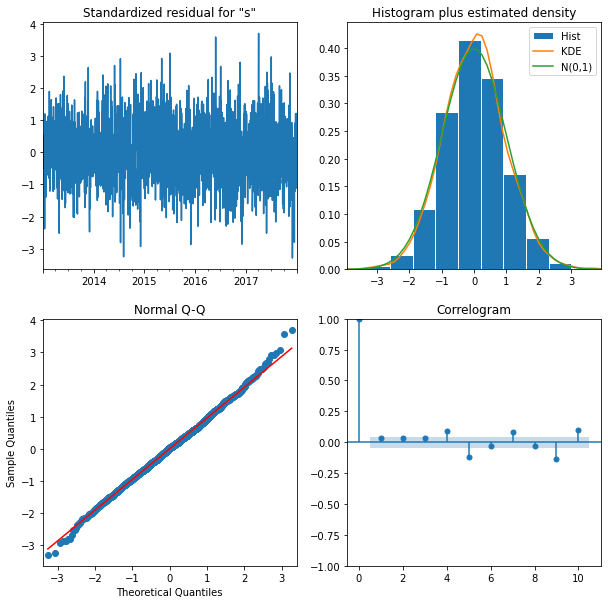

In [85]:
# Create the 4 diagostics plots using plot_diagnostics method
arima_results_02.plot_diagnostics()
plt.show()

In [ ]:
#the AIC and BIC values have decreased from 
# AIC	14868.420 to 14107.022
# BIC	14906.986 to 14178.644

In [ ]:
#the MAE has decreased from 11.161 to 9.037

In [ ]:
#since the seasonal component was ignored lets try with SARIMA model
# as we have looked into the acf and PACF plots the we concluded was 0,1,1,7

In [86]:
sarima_model_01 = SARIMAX(store_1_item_15_ts_df, order=(6,1,6), seasonal_order=(0,1,1,7))
sarima_results_01 = sarima_model_01.fit()

# Calculate the mean absolute error from residuals
sarima_01_mae = np.mean(np.abs(sarima_results_01.resid))

# Print mean absolute error
print('MAE: %.3f' % sarima_01_mae)

C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 8.232


In [87]:
sarima_results_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 6)x(0, 1, [1], 7)   Log Likelihood               -6843.736
Date:                             Tue, 10 Jan 2023   AIC                          13715.472
Time:                                     10:56:28   BIC                          13792.549
Sample:                                 01-01-2013   HQIC                         13743.910
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7477      0.339     -2.205      0.027      -1.412      -0.083
ar.L2          0.1320      0.129      1.025      0.305      -0.120       0.384
ar.L3          0.0013      0.108      0.012      0.991      -0.210       0.212
ar.L4         -0.9086      0.109     -8.340      0.000      -1.122      -0.695
ar.L5         -0.4770      0.293     -1.630      0.103      -1.050       0.096
ar.L6          0.0677      0.033      2.041      0.041       0.003       0.133
ma.L1         -0.0293      0.340     -0.086      0.931      -0.695       0.636
ma.L2         -0.7547      0.222     -3.393      0.001      -1.191      -0.319
ma.L3          0.0180      0.121      0.149      0.882      -0.219       0.255
ma.L4          0.9622      0.114      8.463      0.000       0.739       1.185
ma.L5         -0.2013      0.262     -0.769      0.442      -0.714       0.312
ma.L6         -0.4586      0.241     -1.905      0.057      -0.930       0.013
ma.S.L7       -0.9937      0.005   -184.269      0.000      -1.004      -0.983
sigma2       107.4531      3.389     31.706      0.000     100.811     114.095
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 8.62
Prob(Q):                              0.62   Prob(JB):                         0.01
Heteroskedasticity (H):               1.28   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

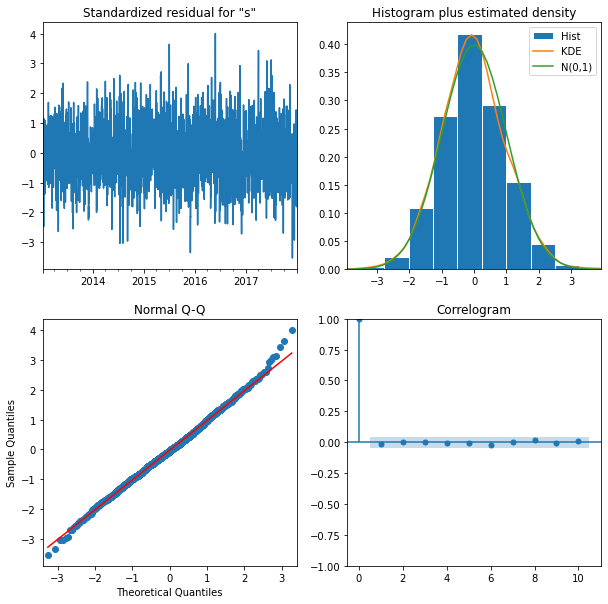

In [88]:
sarima_results_01.plot_diagnostics()
plt.show()

In [ ]:
#from the summary we can conclude
#1. The residuals are white noise
#2. they dont follow normal distribution. there is slight deviation
#3. the residuals are not correlated with each other

In [ ]:
#lets try to find the order using the auto arima 

In [91]:
# Create auto_arima model
model1 = pm.auto_arima(store_1_item_15_ts_df, #time series
                      seasonal=True, # is the time series seasonal
                      m=7, # the seasonal period - one week
                      d=1, # non-seasonal difference order
                      D=1, # seasonal difference order
                 	  max_p=6, # max value of p to test 
                      max_q=6, # max value of q to test
                      max_P=6, # max value of P to test 
                      max_Q=6, # max value of Q to test 
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=6.48 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=15823.667, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=14754.301, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=15320.729, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=14511.811, Time=0.87 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=14419.013, Time=1.61 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=14347.224, Time=2.14 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=14321.218, Time=5.08 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=14292.743, Time=7.90 sec
 ARIMA(1,1,0)(6,1,1)[7]             : AIC=inf, Time=51.10 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=50.98 sec
 ARIMA(0,1,0)(6,1,0)[7]             : AIC=14759.323, Time=7.34 sec
 ARIMA(2,1,0)(6,1,0)[7]             : AIC=14144.627, Time=8.71 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC

In [92]:
sarima_model_02 = SARIMAX(store_1_item_15_ts_df, order=(6,1,1), seasonal_order=(6,1,0,7))
sarima_results_02 = sarima_model_02.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_results_02.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nswet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 8.603


In [93]:
sarima_results_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(6, 1, [], 7)   Log Likelihood               -6918.461
Date:                            Tue, 10 Jan 2023   AIC                          13864.921
Time:                                    12:44:01   BIC                          13941.998
Sample:                                01-01-2013   HQIC                         13893.359
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1546      0.026      5.849      0.000       0.103       0.206
ar.L2          0.0987      0.026      3.801      0.000       0.048       0.150
ar.L3          0.0402      0.026      1.518      0.129      -0.012       0.092
ar.L4          0.1279      0.025      5.034      0.000       0.078       0.178
ar.L5          0.0314      0.026      1.210      0.226      -0.019       0.082
ar.L6          0.0667      0.025      2.685      0.007       0.018       0.115
ma.L1         -0.9526      0.014    -65.735      0.000      -0.981      -0.924
ar.S.L7       -0.8474      0.025    -34.559      0.000      -0.895      -0.799
ar.S.L14      -0.6540      0.031    -20.959      0.000      -0.715      -0.593
ar.S.L21      -0.4830      0.035    -13.922      0.000      -0.551      -0.415
ar.S.L28      -0.3610      0.036    -10.149      0.000      -0.431      -0.291
ar.S.L35      -0.2343      0.030     -7.704      0.000      -0.294      -0.175
ar.S.L42      -0.1228      0.024     -5.153      0.000      -0.170      -0.076
sigma2       117.6631      3.790     31.046      0.000     110.235     125.091
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.97   Prob(JB):                         0.41
Heteroskedasticity (H):               1.29   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

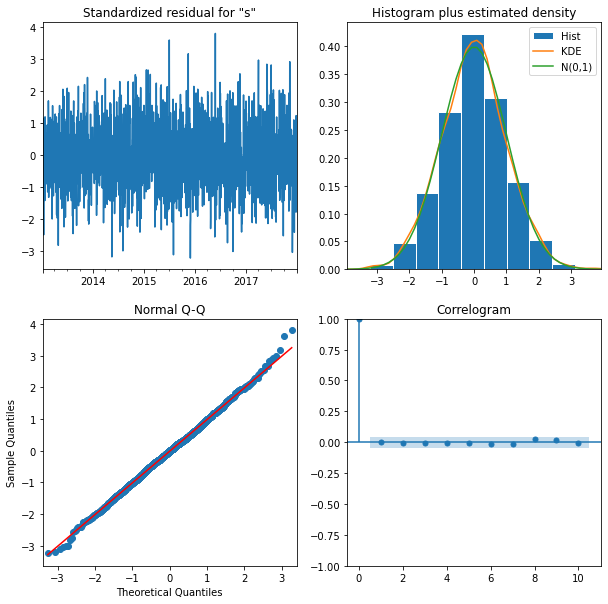

In [94]:
# Create the 4 diagostics plots
sarima_results_02.plot_diagnostics()
plt.show()

In [ ]:
#The MAE from the Sarima 01 and Sarima 02 model slightly increased 
# the AIC and BIC values have also increased

# AIC	13715.472 to AIC	13864.921
# BIC	13792.549 to BIC	13941.998

In [95]:
# Create ARIMA mean forecast
arima_pred = arima_results_02.get_prediction(start=-90, dynamic=True)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_pred_01 = sarima_results_01.get_prediction(start=-90, dynamic=True)
sarima_mean_01 = sarima_pred_01.predicted_mean

# Create SARIMA mean forecast
sarima_pred_02 = sarima_results_02.get_prediction(start=-90, dynamic=True)
sarima_mean_02 = sarima_pred_02.predicted_mean

In [97]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

metrics_arima = [round(mean_absolute_error(store_1_item_15_ts_df[-90:],arima_mean),3), 
                 round(mean_absolute_percentage_error(store_1_item_15_ts_df[-90:],arima_mean),3)]
metrics_sarima_01 = [round(mean_absolute_error(store_1_item_15_ts_df[-90:],sarima_mean_01),3), 
                       round(mean_absolute_percentage_error(store_1_item_15_ts_df[-90:],sarima_mean_01),3)]
metrics_sarima_02 = [round(mean_absolute_error(store_1_item_15_ts_df[-90:],sarima_mean_02),3),
                       round(mean_absolute_percentage_error(store_1_item_15_ts_df[-90:],sarima_mean_02),3)]
df_arima_results = pd.DataFrame({'metrics':['MAE','MAPE'],
                                 'ARIMA(6,1,6)':metrics_arima, 
                                 'SARIMA(6,1,6)(0,1,1)7':metrics_sarima_01,
                                 'SARIMA(6,1,1)(6,1,0)7':metrics_sarima_02,
                                })

df_arima_results

,metrics,"ARIMA(6,1,6)","SARIMA(6,1,6)(0,1,1)7","SARIMA(6,1,1)(6,1,0)7"
0,MAE,12.906,12.662,15.083
1,MAPE,0.169,0.168,0.172


In [98]:
df_arima_results.to_csv("final_results_sarima.csv", index=False)

In [ ]:
### Comparing model Arima and Sarima

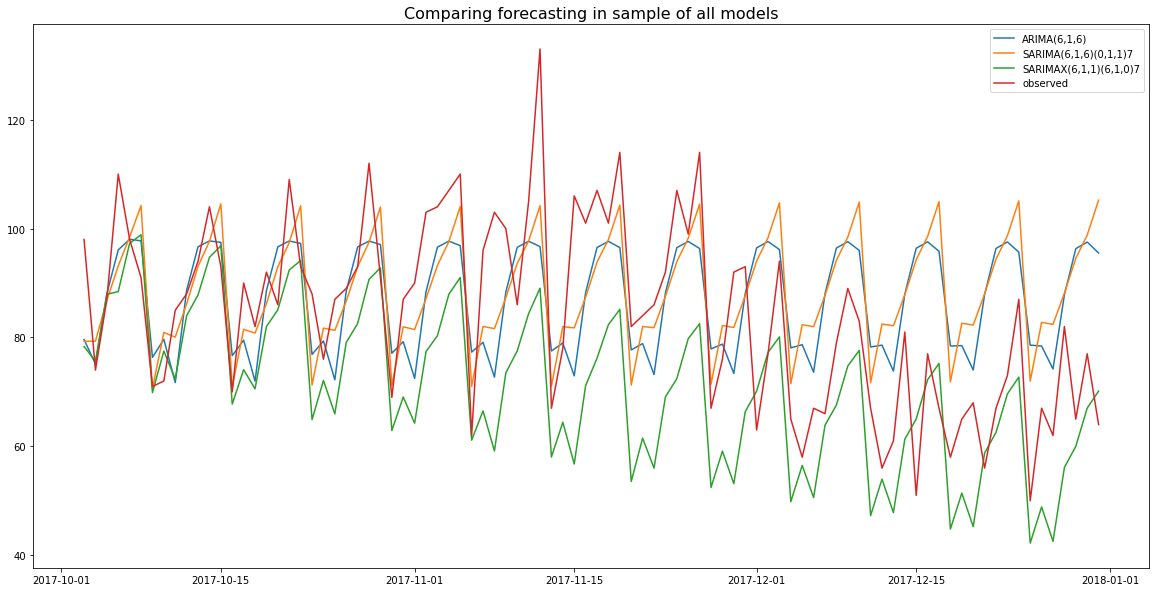

In [100]:
dates = store_1_item_15_ts_df.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.figure(figsize=(20,10))
plt.title('Comparing forecasting in sample of all models', size = 16)
plt.plot(arima_mean.index, arima_mean, label='ARIMA(6,1,6)')
plt.plot(sarima_mean_01.index, sarima_mean_01, label='SARIMA(6,1,6)(0,1,1)7')
plt.plot(sarima_mean_02.index, sarima_mean_02, label='SARIMAX(6,1,1)(6,1,0)7')
plt.plot(store_1_item_15_ts_df[-90:], label='observed')
plt.legend()
plt.show()

In [ ]:
#The orange graph closely follows the red graph
#from the MAE and MAPE we can observe that the Sarima 01 model was perfroming better

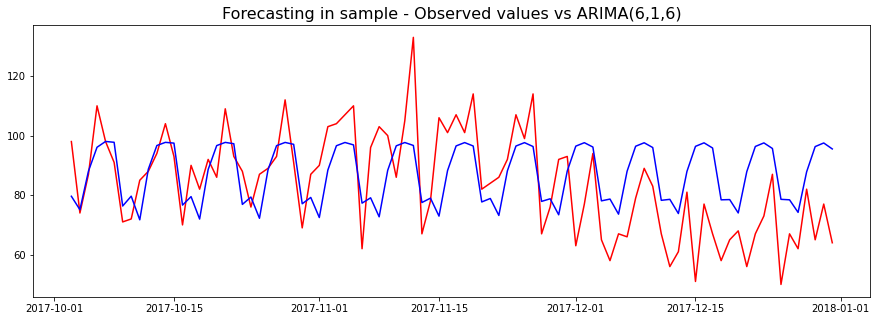

In [101]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs ARIMA(6,1,6)', size = 16)
plt.plot(store_1_item_15_ts_df[-90:], label='observed', color='red')
plt.plot(arima_mean.index, arima_mean, label='ARIMA(6,1,6)', color='blue')

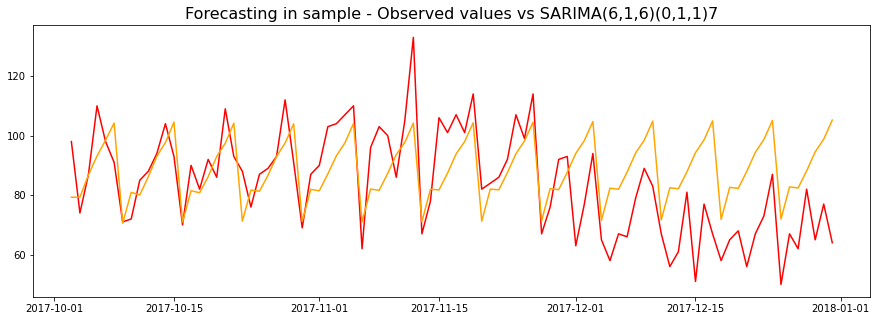

In [106]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs SARIMA(6,1,6)(0,1,1)7', size = 16)
plt.plot(store_1_item_15_ts_df[-90:], label='observed', color='red')
plt.plot(sarima_mean_01.index, sarima_mean_01, label='SARIMA(6,1,6)(0,1,1)7', color='orange')

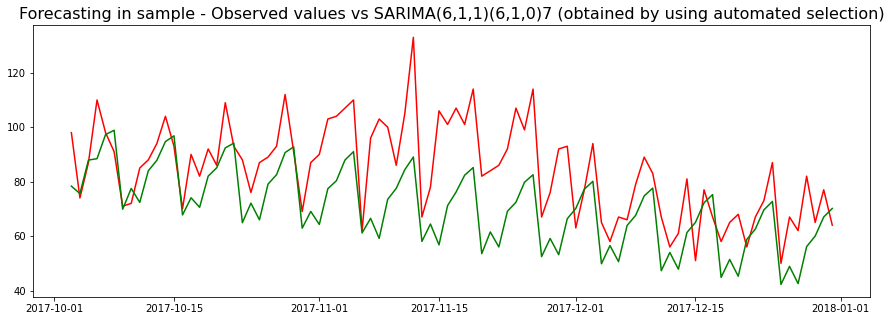

In [105]:
plt.figure(figsize=(15,5))
plt.title('Forecasting in sample - Observed values vs SARIMA(6,1,1)(6,1,0)7 (obtained by using automated selection)', size = 16)
plt.plot(store_1_item_15_ts_df[-90:], label='observed', color='red')
plt.plot(sarima_mean_02.index, sarima_mean_02, label='SARIMA(6,1,1)(6,1,0)7', color='green')

### Forecast

In [118]:
# Create ARIMA mean forecast
arima_pred = arima_results_02.get_forecast(steps=90)
arima_mean = arima_pred.predicted_mean
# ARIMA predictions
arima_mean

2018-01-01    58.894420
2018-01-02    62.462326
2018-01-03    57.226812
2018-01-04    68.657394
2018-01-05    73.697097
                ...    
2018-03-27    60.164589
2018-03-28    59.098912
2018-03-29    68.287159
2018-03-30    73.344212
2018-03-31    73.864186
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [119]:
# Create SARIMA mean forecast
sarima_pred_01 = sarima_results_01.get_forecast(steps=90)
sarima_mean_01 = sarima_pred_01.predicted_mean
# SARIMA predictions
sarima_mean_01

2018-01-01    49.181654
2018-01-02    59.819940
2018-01-03    59.965019
2018-01-04    64.298611
2018-01-05    68.991200
                ...    
2018-03-27    58.366670
2018-03-28    58.430935
2018-03-29    64.110353
2018-03-30    69.854558
2018-03-31    74.444396
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [124]:
# Create SARIMA mean forecast
sarima_pred_02 = sarima_results_02.get_forecast(steps=90)
sarima_mean_02 = sarima_pred_02.predicted_mean
# SARIMA predictions
sarima_mean_02

2018-01-01    50.122493
2018-01-02    52.801118
2018-01-03    62.019555
2018-01-04    63.633292
2018-01-05    59.647639
                ...    
2018-03-27     8.920437
2018-03-28    13.326056
2018-03-29    18.989671
2018-03-30    12.020689
2018-03-31    22.884692
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

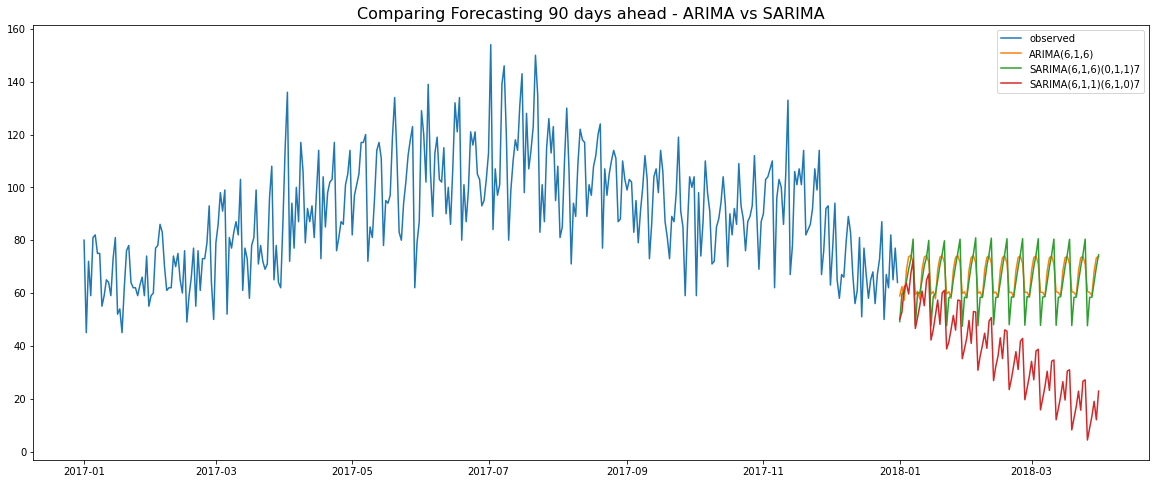

In [125]:
dates = store_1_item_15_ts_df.index
plt.figure(figsize=(20,8))
# Plot mean ARIMA and SARIMA predictions and observed
plt.title("Comparing Forecasting 90 days ahead - ARIMA vs SARIMA", size = 16)
plt.plot(store_1_item_15_ts_df['2017':], label='observed')
plt.plot(arima_mean.index, arima_mean, label='ARIMA(6,1,6)')
plt.plot(sarima_mean_01.index, sarima_mean_01, label='SARIMA(6,1,6)(0,1,1)7')
plt.plot(sarima_mean_02.index, sarima_mean_02, label='SARIMA(6,1,1)(6,1,0)7')
plt.legend()
plt.show()

In [128]:
# Import joblib
import joblib

# Set model name
filename = "store_1_item_15_ts_df.pkl"

# Pickle it
joblib.dump(sarima_model_02,filename)


['store_1_item_15_ts_df.pkl']

In [129]:
filename = "store_1_item_15_ts_df.pkl"
loaded_model = joblib.load(filename)
loaded_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(6, 1, [], 7)   Log Likelihood               -6918.461
Date:                            Tue, 10 Jan 2023   AIC                          13864.921
Time:                                    13:08:09   BIC                          13941.998
Sample:                                01-01-2013   HQIC                         13893.359
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2653      0.000   -831.498      0.000      -0.266      -0.265
ar.L2         -0.2079      0.000   -510.603      0.000      -0.209      -0.207
ar.L3         -0.1938      0.000   -443.929      0.000      -0.195      -0.193
ar.L4         -0.0738      0.001    -87.159      0.000      -0.075      -0.072
ar.L5          0.0812      0.001     95.907      0.000       0.080       0.083
ar.L6          0.3089      0.000   1127.716      0.000       0.308       0.309
ma.L1         -0.4477      0.000  -2368.626      0.000      -0.448      -0.447
ar.S.L7       -0.8937   9.47e-05  -9437.370      0.000      -0.894      -0.894
ar.S.L14      -0.7116      0.000  -5983.171      0.000      -0.712      -0.711
ar.S.L21      -0.5276      0.000  -3288.866      0.000      -0.528      -0.527
ar.S.L28      -0.4005      0.000  -1895.594      0.000      -0.401      -0.400
ar.S.L35      -0.2464      0.000   -717.281      0.000      -0.247      -0.246
ar.S.L42      -0.1197      0.001   -169.288      0.000      -0.121      -0.118
sigma2       197.4742   4.29e-07   4.61e+08      0.000     197.474     197.474
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.97   Prob(JB):                         0.41
Heteroskedasticity (H):               1.29   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.23e+33. Standard errors may be unstable.
"""